In [1]:
from __future__ import print_function
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm_notebook, tqdm, trange
print(torch.__version__)

1.0.0


In [2]:
device = torch.device("cuda")
# Hyper Parameter
batch_size = 61440
epoch = 35
learning_rate = 0.01

train_loader = torch.utils.data.DataLoader(
                    datasets.MNIST('../data', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])),
                    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                    datasets.MNIST('../data', train=False, 
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])),
                    batch_size=10240, shuffle=True)

print(len(train_loader))
print(len(test_loader))

1
1


In [3]:
# Declare Neural Network Layer
weights1 = torch.randn((784, 500), dtype=torch.float32, requires_grad=True, device = device)
weights2 = torch.randn((500, 250), dtype=torch.float32, requires_grad=True, device = device)
weights3 = torch.randn((250, 10), dtype=torch.float32, requires_grad=True, device = device)

# Build forward / loss / one-hot function
def forward(data, weights):
    
    length = len(weights)
    
    out = data
    for i in range(length - 1):
        out = torch.matmul(out, weights[i])        
        out = torch.sigmoid(out)        
    else:
        out = torch.matmul(out, weights[-1])
        
    return out

def mse(out, logits):
    n = out.shape[0]
    loss_matric = out - logits
    loss_matric = torch.mul(loss_matric, loss_matric)
    loss_matric = torch.sqrt(loss_matric)
    
    return torch.div(torch.sum(loss_matric), n)

def one_hot(batch,depth):
    ones = torch.eye(depth)
    return ones.index_select(0,batch)

def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

def derivate_sigmoiod(data):
    return torch.sigmoid(data)*(1 - torch.sigmoid(data))

In [4]:
loss = 0
total_bar_length = tqdm_notebook(range(epoch))
train_loss_hist = list()
test_loss_hist = list()

test_loader_iter = enumerate(test_loader)

for epoch in total_bar_length:
    
    if epoch == 15:
        learning_rate = 0.001
    elif epoch == 20:
        learning_rate = 0.0005
    elif epoch == 25:
        learning_rate = 0.00008
    
    for batch_id, (data, target) in enumerate(train_loader):

        weights = [weights1, weights2, weights3]
        
        # Train
        batch, _, _, _ = data.shape
        data = data.view(batch, -1).cuda()
        target = one_hot(target, 10).cuda()

        out = forward(data, weights)
        loss = mse(out, target)
        loss.backward()
        
        with torch.no_grad():            
            weights1 -= learning_rate * weights1.grad
            weights2 -= learning_rate * weights2.grad
            weights3 -= learning_rate * weights3.grad
            
            weights1.grad.zero_()
            weights2.grad.zero_()
            weights3.grad.zero_()
        
        # Test
        with torch.no_grad():            
            for batch_id, (test_data, test_target) in enumerate(test_loader):
                test_batch, _, _, _ = test_data.shape
                test_data = test_data.view(test_batch, -1).cuda()
                test_target = one_hot(test_target, 10).cuda()

                test_out = forward(test_data, weights)
                test_loss = mse(test_out, test_target)

                train_loss_hist.append(loss)
                test_loss_hist.append(test_loss)
                print("Epoch : {}, Step : {}, train_loss : {}, val_loss : {}".format(epoch, batch_id, loss, test_loss))


Epoch : 0, Step : 0, train_loss : 70.06514739990234, val_loss : 64.85477447509766
Epoch : 1, Step : 0, train_loss : 65.18498992919922, val_loss : 60.70122528076172
Epoch : 2, Step : 0, train_loss : 61.03861999511719, val_loss : 57.23352813720703
Epoch : 3, Step : 0, train_loss : 57.57139587402344, val_loss : 54.392642974853516
Epoch : 4, Step : 0, train_loss : 54.735713958740234, val_loss : 52.11648178100586
Epoch : 5, Step : 0, train_loss : 52.45427322387695, val_loss : 50.3231315612793
Epoch : 6, Step : 0, train_loss : 50.64928436279297, val_loss : 48.93071746826172
Epoch : 7, Step : 0, train_loss : 49.24208450317383, val_loss : 47.859031677246094
Epoch : 8, Step : 0, train_loss : 48.15715026855469, val_loss : 47.04037857055664
Epoch : 9, Step : 0, train_loss : 47.33192443847656, val_loss : 46.41175079345703
Epoch : 10, Step : 0, train_loss : 46.7036018371582, val_loss : 45.92889404296875
Epoch : 11, Step : 0, train_loss : 46.221134185791016, val_loss : 45.55424118041992
Epoch : 12, 

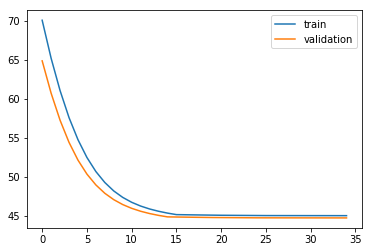

In [5]:
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="validation")
plt.legend()
plt.show()